# Libaries and Requirements

In [1]:
# install.packages("tfprobability", lib="/usr/local/lib/R/site-library")
# tfprobability::install_tfprobability()
# library(reticulate)
# library(tensorflow)
# library(keras)
# library(tfprobability)
# tf$compat$v2$enable_v2_behavior()
# install.packages("corrr")
library(tidymodels) # for readability 
library(data.table) # for speed on data frames
library(ggplot2) # visualizations
library(readr)
library(skimr) # to get a fast grasp of the dataset 
library(GGally)
library(purrr) # for fast plotting multiple ggplots
library(patchwork) # for allocating multiple ggplots easily
library(corrr)
library(corrplot)
library(rlang) # for creating functions of ggplots

── Attaching packages ────────────────────────────────────── tidymodels 0.1.3 ──

✔ broom        0.7.6      ✔ recipes      0.1.16
✔ dials        0.0.9      ✔ rsample      0.0.9 
✔ dplyr        1.0.5      ✔ tibble       3.1.1 
✔ ggplot2      3.3.3      ✔ tidyr        1.1.3 
✔ infer        0.5.4      ✔ tune         0.1.3 
✔ modeldata    0.1.0      ✔ workflows    0.2.2 
✔ parsnip      0.1.5      ✔ workflowsets 0.0.2 
✔ purrr        0.3.4      ✔ yardstick    0.0.8 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
● Use tidymodels_prefer() to resolve common conflicts.


Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last



Attaching package: ‘readr’


The following obj

# Dataset and basic exploration

In [2]:
library(readr)
wine <- as.data.table(read_csv("../input/wine-data/wine.csv"))
skim(wine)


── Column specification ────────────────────────────────────────────────────────
cols(
  fixed.acidity = col_double(),
  volatile.acidity = col_double(),
  citric.acid = col_double(),
  residual.sugar = col_double(),
  chlorides = col_double(),
  free.sulfur.dioxide = col_double(),
  total.sulfur.dioxide = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double(),
  type = col_double()
)




── Data Summary ────────────────────────
                           Values
Name                       wine  
Number of rows             4898  
Number of columns          13    
_______________________          
Column type frequency:           
  numeric                  13    
________________________         
Group variables            None  

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable        n_missing complete_rate     mean       sd    p0     p25
 1 fixed.acidity                0             1   6.85    0.844   3.8     6.3  
 2 volatile.acidity             0             1   0.278   0.101   0.08    0.21 
 3 citric.acid                  0             1   0.334   0.121   0       0.27 
 4 residual.sugar               0             1   6.39    5.07    0.6     1.7  
 5 chlorides                    0             1   0.0458  0.0218  0.009   0.036
 6 free.sulfur.dioxide          0             1  35.3    17.0     2      23    
 7 total.su

* No missing values
* Vastly different scales - needs scaling
* Mostly numeric with two factor type features (type and quality)

# PCA for explainability

In [3]:
library(broom)
library(tidytext)

#remove target
wine.X <- wine %>% select(-type)
wine.y <- wine %>% select(type)

# center and decompose
wine.cntr.X <- t(t(wine.X) - colMeans(wine.X))
svd.results <- svd(wine.cntr.X)

Saving 12.5 x 6.67 in image



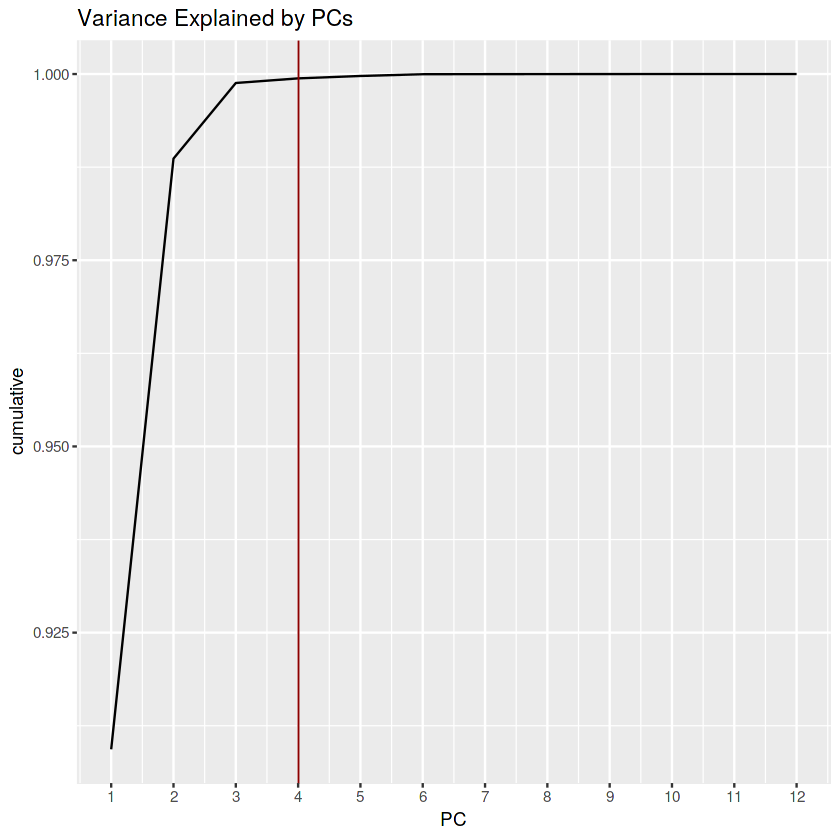

In [4]:
# interpret variance explained 
svd.var.exp <- tidy(svd.results, matrix="d")

svd.var.exp %>% ggplot(aes(x=PC, cumulative)) + 
                geom_line() + 
                geom_vline(xintercept = 4, color = "red4", size=0.4) +
                scale_x_continuous(breaks = seq(min(svd.var.exp$PC),max(svd.var.exp$PC),by=1)) +
                coord_cartesian(xlim=c(1,12)) +
                labs(title = "Variance Explained by PCs")
ggsave("pca-var-expl.pdf", device = "pdf")

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

Saving 12.5 x 6.67 in image



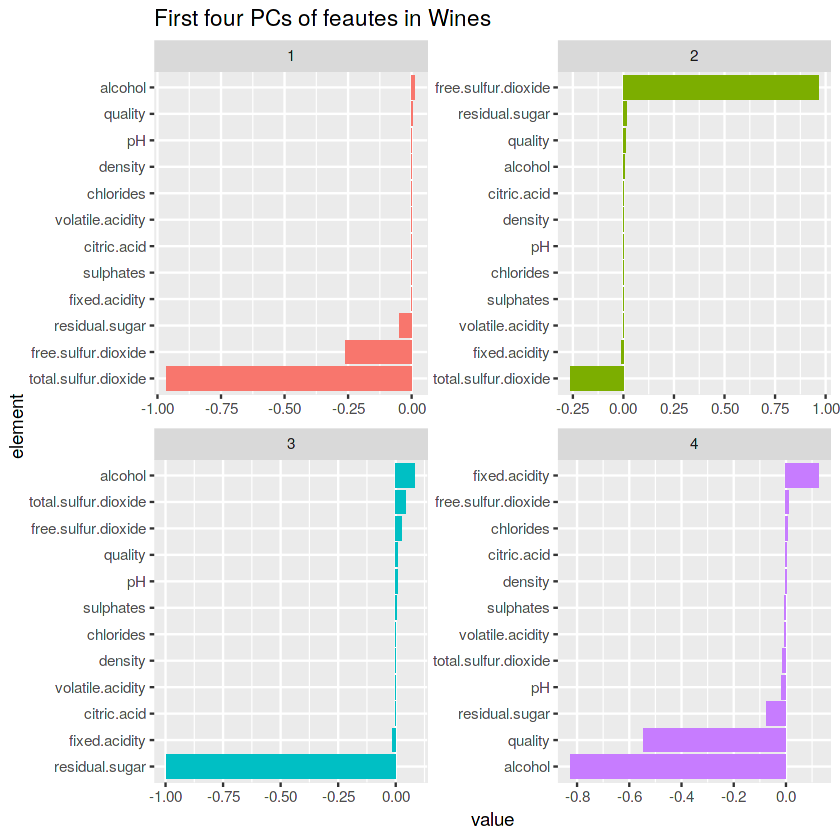

In [5]:
# interpret loadings - working on columns
svd.loadings <- tidy(svd.results, matrix="v") %>%
                mutate(element = colnames(wine.cntr.X)[column])

svd.loadings %>% filter(PC<=4) %>%
                 group_by(PC) %>%
                 top_n(12, abs(value)) %>%
                 ungroup() %>%
                 mutate(element = reorder_within(element, value, PC)) %>%
                 ggplot(aes(x=element, y=value, fill=factor(PC))) +
                 geom_col(show.legend = FALSE) +
                 facet_wrap(~PC, scales="free") +
                 scale_x_reordered() + 
                 coord_flip() +
                 labs(title = "First four PCs of feautes in Wines")
ggsave("pca-features.pdf", device = "pdf")

* PC1: alcohol vs sulfur (total.sulfur.dioxide)
* PC2: total.surfure.dioxide vs free.surfuredioxide
* PC3: alcohol vs residual.sugar
* PC4: fixed.acidity vs alcohol

The variance is explained by:
alcohol degrees vs bad smells, then by the distinction of free and total sulfur. 
Afterwards, the precentage of alcohol degrees compared to the residual sugar and lastly 
by distinguishing between acidity and alcohol. So in summary:
1. Alcohol vs unpleasant oddors
2. Where the unpleasant oddors are coming from
3. Alcohol vs sweatness 
4. Alcohol vs acidity

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

Saving 12.5 x 6.67 in image



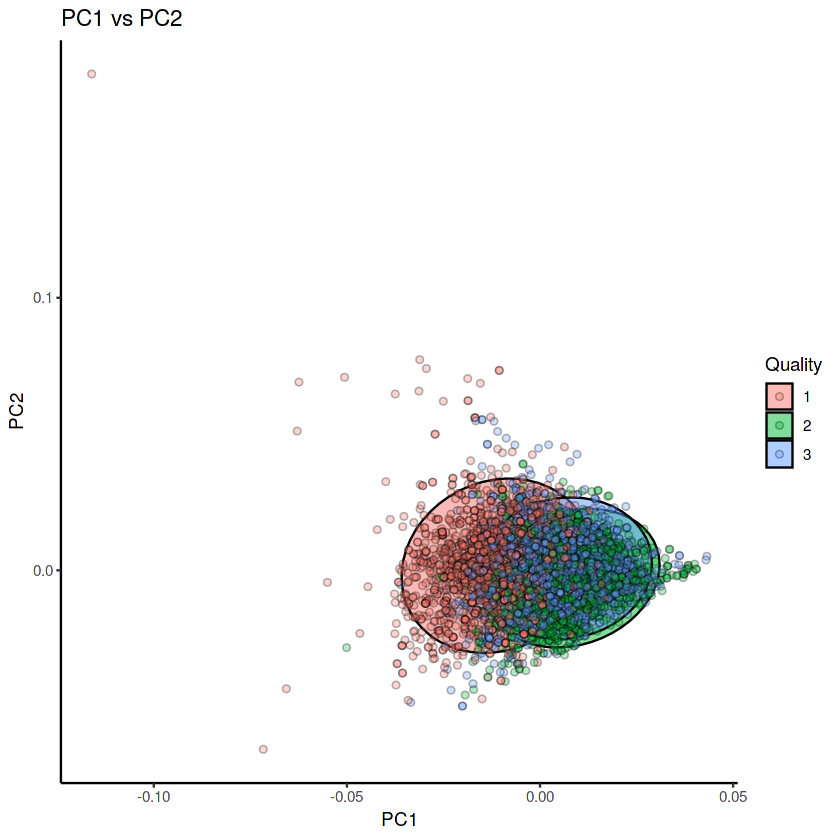

In [6]:
# final plot
svd.pcs <- tidy(svd.results, matrix="u") 

svd.pcs.1 <- svd.pcs %>% filter(PC==1) %>%
             mutate(PC1=value) %>%
             select(PC1)
svd.pcs.2 <- svd.pcs %>% filter(PC==2) %>%
             mutate(PC2=value) %>%
             select(PC2)
svd.pcs.3 <- svd.pcs %>% filter(PC==3) %>%
             mutate(PC3=value) %>%
             select(PC3)
wine.pcs <- cbind(wine.y, svd.pcs.1, svd.pcs.2, svd.pcs.3)

wine.pcs %>%
ggplot(aes(x=PC1, y=PC2, col=type, fill=factor(type))) + 
stat_ellipse(geom="polygon", col="black", alpha=0.5) + 
geom_point(shape=21, col="black", alpha=0.3) +
# stat_binhex() +
labs(title = "PC1 vs PC2", fill="Quality") +
theme_classic()
ggsave("pca-biplot.pdf", device = "pdf")

In [7]:
# 3d plot of PCA no better results
# library(plotly)
# temp <- wine.pcs$PC1
# pressure <- wine.pcs$PC2
# dtime <- wine.pcs$PC3
# gr <- factor(wine.pcs$type)
# plot_ly(x=temp, y=pressure, z=dtime, type="scatter3d", mode="markers", color=gr)

# Univariate Analysis

In [8]:
plot.univariate <- function(var, density, dat=wine){
    
    if(var=="type"){
        density=FALSE
        color="darkorange3"
    } else if(var=="quality"){
        density=FALSE
        color="blue4"
    } else {
        density=TRUE
        color="blue4"
    }
        
    if(density){
        gg.var <- ggplot(data=wine, aes(x=.data[[var]])) +
        geom_density(col=color, fill=color, alpha=0.8) +
        scale_x_continuous() +
        theme(axis.title.x=element_blank(),
              axis.title.y=element_blank()) + 
        ggtitle(var)
    } else {
        gg.var <- ggplot(data=wine, aes(x=.data[[var]])) +
        geom_histogram(col=color, fill=color, alpha=0.7, bins = 30) +
        scale_x_continuous() +
        theme(axis.title.x=element_blank(),
              axis.title.y=element_blank()) + 
        ggtitle(var)
    }
    return(gg.var)
}

Saving 12.5 x 6.67 in image



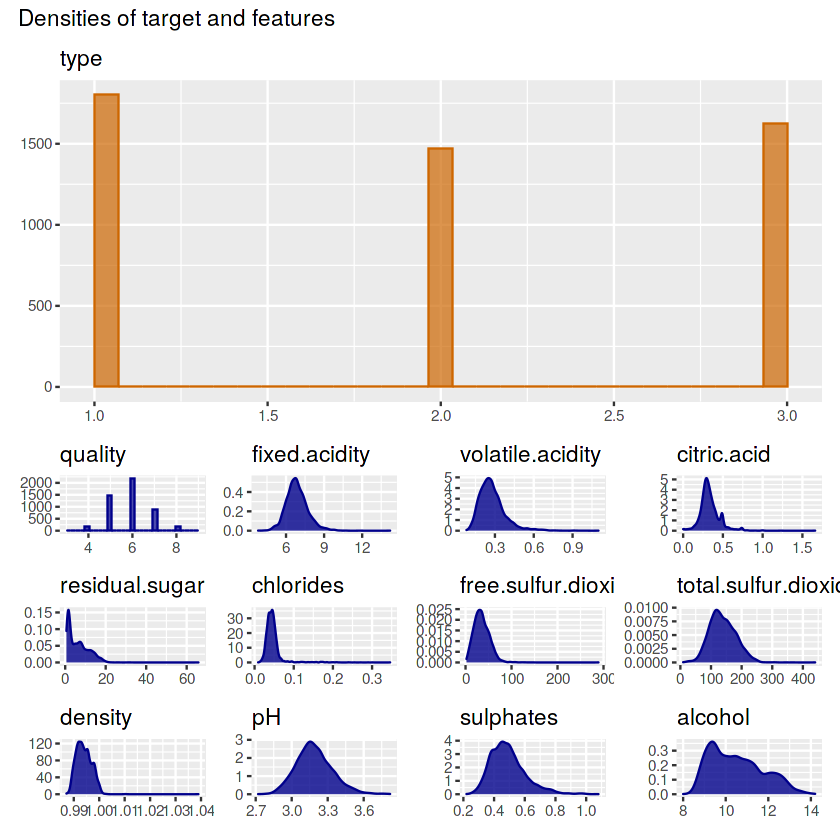

In [9]:
names <- names(wine)
names <- set_names(names)
plots <- map(names, ~plot.univariate(.x))
plots[[13]] + {
plots[[12]] + plots[[1]] + plots[[2]]  + plots[[3]]  +
plots[[4]]  + plots[[5]] + plots[[6]]  + plots[[7]]  +
plots[[8]]  + plots[[9]] + plots[[10]] + plots[[11]] + plot_layout(ncol=4, nrow=3)} + plot_layout(ncol=1) + plot_annotation(title='Densities of target and features')
ggsave("univariate-analysis.pdf", device = "pdf")

# Bivariate Analysis

Saving 12.5 x 6.67 in image



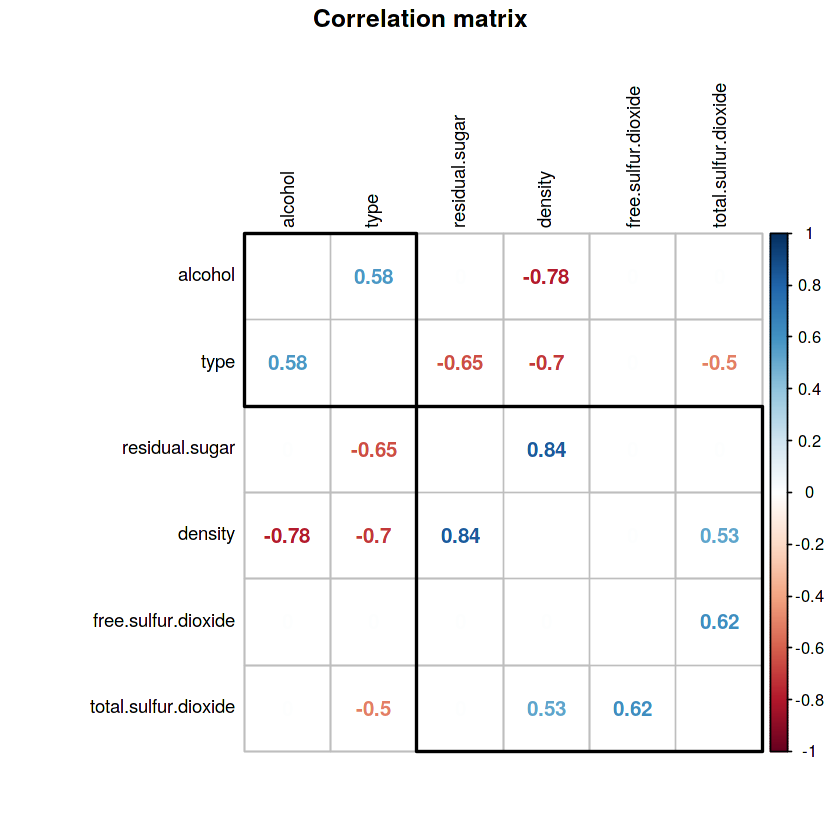

In [10]:
numcols <- sapply(wine, is.numeric) 
wine.corr <- wine[, ..numcols] %>% cor(use="pairwise.complete")
wine.corr.big <- wine.corr*(abs(wine.corr)>0.5)

wine.corr.big <- wine.corr.big[-which(abs(rowSums(wine.corr.big))==1),-which(abs(colSums(wine.corr.big))==1)]
square.cor <- corrplot(wine.corr.big,
                       order="hclust",
                       addrect=2,
                       method='number',
                       diag=FALSE,
                       tl.col="black",
                       tl.cex = 0.9,
                       outline=TRUE,
                       title="Correlation matrix",
                       cl.lim=c(-1, 1),
                       mar=c(0,0,1.5,0))
ggsave("corrplot-1.pdf", device = "pdf")

Saving 12.5 x 6.67 in image



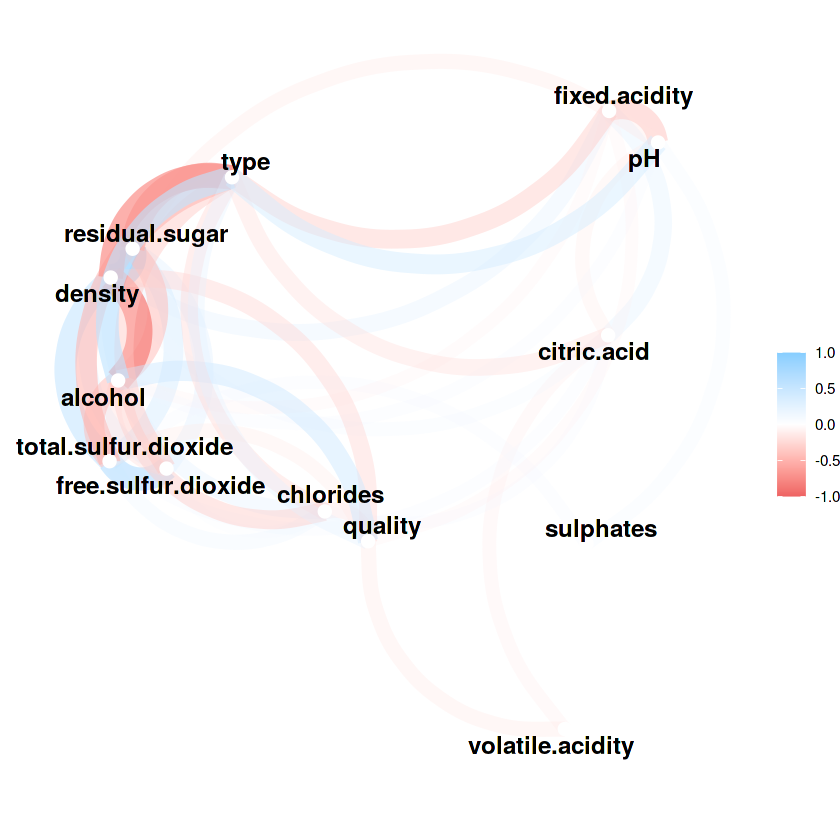

In [11]:
# Same information as aboce, different visualization
wine.corr <- as.data.frame(wine.corr)
wine.corr[wine.corr==1 ] <- NA
wine.corr %>% network_plot(min_cor=0.1)
ggsave("corplot-2.pdf", device = "pdf")

# Multivariate Analysis

In [12]:
plot.multi <- function(dat, var1, var2, fct){
    
    gg.plot <- ggplot(data=dat, aes(x={{ var1 }}, y={{ var2 }}, col=factor( {{ fct }} ))) +
        geom_jitter(alpha=0.5) +
        facet_wrap(~factor({{fct}})) +
        geom_smooth(formula=y~x, method='lm') + 
        expand_limits(x=0, y=0) +
        theme(axis.title.x=element_blank(),
              axis.title.y=element_blank(), 
              legend.position='none') + 
        ggtitle("Linear relation per quality bucket")
        return(gg.plot)
}

In [13]:
wrap_by <- function(...){
    # helper function to avoid an error!
    facet_wrap(vars(...))
}

plot.multi <- function(dat, var1, var2, fct){
    gg.plot <- ggplot(data=dat, aes(x={{ var1 }}, y={{ var2 }}, col={{ fct }} )) +
        geom_jitter(alpha=0.5) +
        wrap_by({{fct}}) + 
        geom_smooth(formula=y~x, method='lm') + 
        # expand_limits(x=0, y=0)  +
        theme(legend.position='none')
        return(gg.plot)
}

Saving 12.5 x 6.67 in image



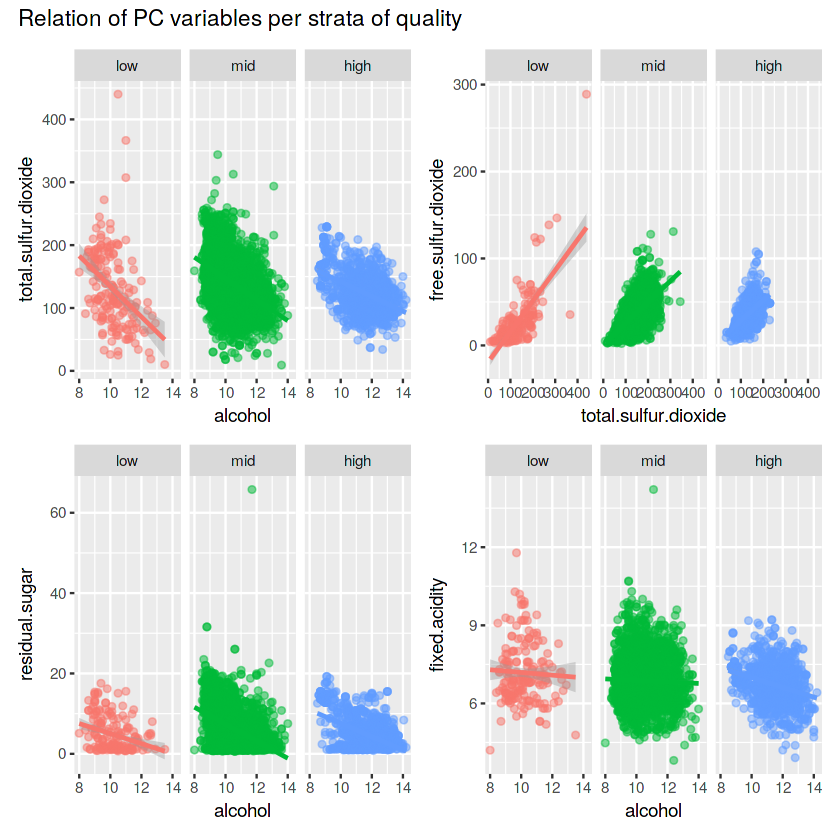

In [14]:
# group wine by quality and plot densities with the variables produced by PCA.
wine.multi <- wine %>% mutate(quality.bucket = case_when(
                    quality < 5 ~ "low",
                    quality < 7 ~ "mid",
                    TRUE ~ "high")) 

pc1.expl <- plot.multi(dat=wine.multi, var1=alcohol, var2=total.sulfur.dioxide,
                    fct=factor(quality.bucket, levels=c('low', 'mid', 'high')))

pc2.expl <- plot.multi(dat=wine.multi, var1=total.sulfur.dioxide, var2=free.sulfur.dioxide,
                    fct=factor(quality.bucket, levels=c('low', 'mid', 'high')))

pc3.expl <- plot.multi(dat=wine.multi, var1=alcohol, var2=residual.sugar,
                    fct=factor(quality.bucket, levels=c('low', 'mid', 'high')))

pc4.expl <- plot.multi(dat=wine.multi, var1=alcohol, var2=fixed.acidity,
                    fct=factor(quality.bucket, levels=c('low', 'mid', 'high')))

pc1.expl + pc2.expl + pc3.expl + pc4.expl + plot_layout(ncol=2, nrow=2) + plot_annotation(title='Relation of PC variables per strata of quality')
ggsave("multivariate-analysis.pdf", device = "pdf")